<a href="https://colab.research.google.com/github/edtechequity/ml_fairness_toolkit/blob/master/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This module includes code to: 
- Learn and understand different optimization functions
- Examine feature importance
- Discuss and consider statistical fairness

In [0]:
import pandas as pd 
import time
import numpy
import matplotlib.pyplot as plt
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances
from numpy import loadtxt
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 112kB 2.7MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# Import data

We will be using the same dataset we used for the dataset module. You can redownload it from Kaggle [here](https://www.kaggle.com/danofer/compass/data#cox-violent-parsed_filt.csv) if you need to. The file we'll be using is propublica_data_for_fairml.csv--the same as before.

## Load dataset

In [0]:
df = pd.read_csv('propublica_data_for_fairml.csv')  

In [0]:
df.head()

,Two_yr_Recidivism,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor
0,0,0,0,1,0,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0
2,1,4,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,1
4,1,14,1,0,0,0,0,0,0,0,0,0


In [0]:
df.shape

(6172, 12)

## Split data

In [0]:
# X values 
X = df.iloc[:,1:]
X.head()

,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor
0,0,0,1,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,0
2,4,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,1
4,14,1,0,0,0,0,0,0,0,0,0


In [0]:
# y values 
y = df.iloc[:,0]
y.head()

0    0
1    1
2    1
3    0
4    1
Name: Two_yr_Recidivism, dtype: int64

# Training task

Our goal is to use the above data to try to predict whether an inmmate will recidivate within 2 years. If you'll recall from the Ideation stage, this is a supervised machine learning problem because we have a defined task with labeled data to support it. Essentially, we want to create a function that looks something like this:

```
f (data_on_person) = (likelihood that person will recidivate) = {0,1}
```

- data_on_person means all of the columns listed above: number of prior convictions (Number_of_Priors), whether they are older than 45 (Age_Above_FourtyFive), and so on.  
- 0 = person did not recidivate and 1 = person did recidivate within 2 years. 

## A simple neural network

Here's a basic neural network we will use just for demonstration purposes--your team most likely will have to go through many rounds of testing to create a specialized network for your company if you decide to go the deep learning route. 

There are three [dense](https://keras.io/layers/core/) layers, and the model is compiled with binary crossentropy loss and optimized with stochastic gradient descent. For a discussion of choosing which loss function to use, see [this link](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/). We will figure out the best number of epochs, batch size, and optimizer in hyperparameter tuning later.

Remember that this is only "best" in terms of accuracy and there are many metrics one should weigh when deciding what hyperparameters to use! This example is purposefully simple so we can show feature importance with the fewest steps.  

In [0]:
num_feats = X.shape[1]
num_feats

11

In [0]:
model = Sequential()
model.add(Dense(12, input_dim=num_feats, activation='relu'))
model.add(Dense(num_feats, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [0]:
start = time.time()
history = model.fit(X, y, validation_split=0.2, epochs=10, batch_size=10, verbose=0)

print('time to train: ', time.time() - start)

time to train:  6.49271559715271


## Evaluate

For simplicity here, we are only going to examine the accuracy metric to see how our model did. **Please remember that accuracy is not the only, or necessarily most important, metric!** See [this link](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) for a large list of other metrics your team should consider when choosing a classification model.  

In [0]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


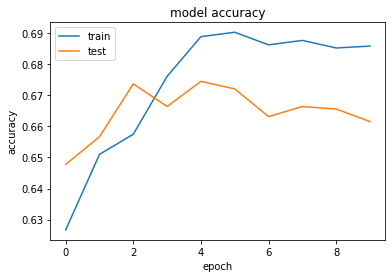

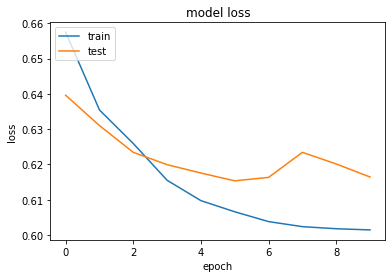

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# train accuracy
_, accuracy = model.evaluate(X_train, y_train)
print('Train Accuracy: %.2f' % (accuracy*100))

# test accuracy
_, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: %.2f' % (accuracy*100))

4937/4937 [==============================] - 0s 20us/step
Train Accuracy: 68.69
1235/1235 [==============================] - 0s 23us/step
Test Accuracy: 66.56


## Grid search 

This is the most naive way to get the "best" model. 

### batch size and epochs

In [0]:
# fix seed for reproducibility 
seed = 42
numpy.random.seed(seed)

In [0]:
def create_model(optimizer='adam'):
  # create model
  model = Sequential()
  model.add(Dense(12, input_dim=num_feats, activation='relu'))
  model.add(Dense(num_feats, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # Compile model
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

In [0]:
model = KerasClassifier(build_fn=create_model, verbose=0)

In [0]:
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100, 150]
param_grid = dict(batch_size=batch_size, epochs=epochs)

In [0]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

start = time.time()
grid_result = grid.fit(X, y)
print('time to fit: ', time.time() - start)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


time to fit:  653.826281785965


In [0]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.683893 using {'batch_size': 10, 'epochs': 10}
0.683893 (0.010905) with: {'batch_size': 10, 'epochs': 10}
0.680977 (0.008798) with: {'batch_size': 10, 'epochs': 50}
0.678708 (0.016034) with: {'batch_size': 10, 'epochs': 100}
0.675792 (0.009192) with: {'batch_size': 10, 'epochs': 150}
0.681786 (0.012149) with: {'batch_size': 20, 'epochs': 10}
0.680004 (0.012080) with: {'batch_size': 20, 'epochs': 50}
0.679842 (0.012180) with: {'batch_size': 20, 'epochs': 100}
0.678870 (0.010814) with: {'batch_size': 20, 'epochs': 150}
0.682921 (0.009208) with: {'batch_size': 40, 'epochs': 10}
0.679032 (0.011154) with: {'batch_size': 40, 'epochs': 50}
0.680977 (0.006082) with: {'batch_size': 40, 'epochs': 100}
0.680329 (0.009008) with: {'batch_size': 40, 'epochs': 150}
0.683082 (0.011098) with: {'batch_size': 60, 'epochs': 10}
0.682759 (0.010650) with: {'batch_size': 60, 'epochs': 50}
0.679194 (0.013179) with: {'batch_size': 60, 'epochs': 100}
0.681463 (0.006619) with: {'batch_size': 60, 'epochs':

### optimizer

In [0]:
# choose best batch size and epochs from above, but change the optimizer 
batch_size = [10]
epochs = [10]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer)

In [0]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

start = time.time()
grid_result = grid.fit(X, y)
print('time to fit: ', time.time() - start)

time to fit:  80.12534642219543


In [0]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.684541 using {'batch_size': 10, 'epochs': 10, 'optimizer': 'SGD'}
0.684541 (0.010777) with: {'batch_size': 10, 'epochs': 10, 'optimizer': 'SGD'}
0.681786 (0.012756) with: {'batch_size': 10, 'epochs': 10, 'optimizer': 'RMSprop'}
0.678060 (0.009592) with: {'batch_size': 10, 'epochs': 10, 'optimizer': 'Adagrad'}
0.682273 (0.010050) with: {'batch_size': 10, 'epochs': 10, 'optimizer': 'Adadelta'}
0.679194 (0.008406) with: {'batch_size': 10, 'epochs': 10, 'optimizer': 'Adam'}
0.680166 (0.009984) with: {'batch_size': 10, 'epochs': 10, 'optimizer': 'Adamax'}
0.681301 (0.011401) with: {'batch_size': 10, 'epochs': 10, 'optimizer': 'Nadam'}


# How important are each of the features?

Now that we know how well our "best" model has done on our task, we should consider: what were the most important variables (features) that led the model to the decisions it made? This is important because as you'll recall in the Training Algorithms section of our guide, we want to know which features our ML model considers most important in making decisions, and see if these line up with your values. If your "best" model has values that don't align with yours, maybe it's time to reconsider what "best" means!

To determine feature importance, we will use the Python package `eli5`. It's useful because it has a [wrapper](https://eli5.readthedocs.io/en/latest/autodocs/sklearn.html#eli5.sklearn.permutation_importance.PermutationImportance) for any black box estimator to do permutation importance (a type of feature importance). You can read their overview of permutation importance [here](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html). 

In [0]:
def score(X, y):
    y_pred = model.predict_classes(X)
    acc = (y == y_pred).mean()
    return acc

X_fix = X.to_numpy()
y_fix = y.to_numpy()
y_fix = y_fix.reshape(-1,1)
base_score, score_decreases = get_score_importances(score, X_fix, y_fix)
feature_importances = np.mean(score_decreases, axis=0)

In [0]:
feature_importances

array([ 8.14322748e-02,  3.60012962e-02,  3.82372003e-03,  1.20868438e-02,
        3.56448477e-04, -1.94426442e-04, -1.62022035e-04,  9.72132210e-05,
       -4.21257291e-04,  4.99027868e-03,  8.74918989e-04])

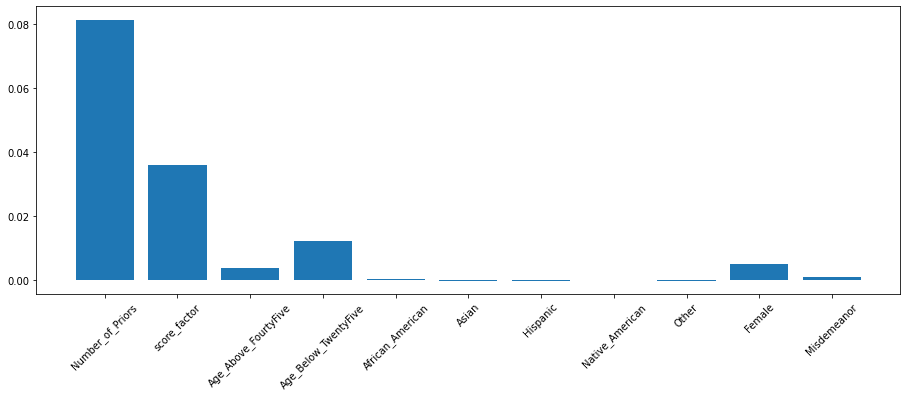

In [0]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar(list(df)[1:],list(feature_importances))
plt.xticks(rotation=45)
plt.show()

# Summary

As we can tell, ProPublica did a great job of making sure the dataset was balanced and had features that reflected their values. The model relies the most heavily on the number of priors and the score factor to determine the likelihood that someone will recidivate in two years. The racial factors are extremely minimal. We can see that age and gender play a small role, but they are still dwarfed by the two main features. As we emphasized in the dataset section, a good dataset is crucial for a good model! 